<a href="https://colab.research.google.com/github/juno2856/deeplearning/blob/master/NLP/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_20220527.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer

기존의 seq2seq 모델의 한계
- 입력 시퀀스를 하나의 벡터표현으로 압축 (context vector) 디코더는 이를 통해 출력 시퀀스를 만들어냄
- 정보가 일부 손실된다는 단점

- $d_{model}$ = 512
- num_layers = 6
- num_heads = 8
- $d_{ff}$ = 2048

## 1.포지셔널 인코딩
https://velog.io/@cha-suyeon/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EC%9D%98-%EC%9E%85%EB%A0%A5-%EC%9D%B4%ED%95%B4

$$PE_(pose, 2i) = sin(pos/10000^{2i/d_{model}})$$
$$PE_(pose, 2i+1) = cos(pos/10000^{2i/d_{model}})$$

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1/tf.pow(10000,(2* (i//2))/tf.cast(d_model, tf.float32))
        return position * angles
        # tf.cast 소수점 버리기, tf.pow 10000^2i

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model = d_model
        )
        # tf.newaxis 차원하나 늘리기 -> 한번만 실행하여야함
    
        # 배열의 짝수 인덱스 (2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:,0::2])

        # 배열의 홀수 인덱스 (2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:,1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...] # ... 앞에 차원 1개 추가하고 전체 출력해주세요

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32) 

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


(1, 50, 128)


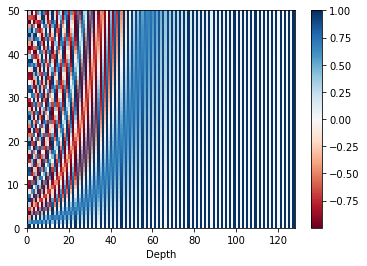

In [ ]:
# 50 * 128크기를 가지는 포지셔널 인코딩 행렬을 시각화 하기
# 입력문자의 단어가 50, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용하는 행렬

sample_pos_encdoing = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encdoing.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.colorbar()
plt.show()

## 2. scaled dot product Attention

encoder self attention



In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬
    matmul_qk = tf.matmul(query, key, transpose_b = True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 됩니다.
    if mask is not None:
        logits += (mask * -1e9)
    
    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis = -1)

    # output : (batch_size, num_heads, query의 문장길이)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [ ]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)

temp_v = tf.constant([[   1, 0],
                     [  10, 0],
                     [  100,5],
                     [1000, 6]], dtype = tf.float32) # (4,2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)

In [ ]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포 (어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)

temp_v = tf.constant([[   1, 0],
                     [  10, 0],
                     [  100,5],
                     [1000, 6]], dtype = tf.float32) # (4,2)

temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32) # (1, 3)

In [ ]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포 (어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)

temp_v = tf.constant([[   1, 0],
                     [  10, 0],
                     [  100,5],
                     [1000, 6]], dtype = tf.float32) # (4,2)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32) # (1, 3)

In [ ]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포 (어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Encoder

### 멀티-헤드 어텐션

- 병렬 어텐션의 효과?  
머리가 여러개이기 때문에, 여러 시점에서 상대방을 볼 수 있다!

1. $W_Q$,$W_k$, $W_v$에 해당하는 $d_{model}$크기의 밀집층(Dense layer)을 지남  
2. 지정된 헤드 수 (num_heads)만큼 나눈다.
3. 스케일드 닷 어텐션
4. 나눠졌던 헤드를 연결한다.
5. $W_0$에 해당하는 밀집층을 지나게 된다.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0  # assert 해당 내용이 만족하지않으면 오류메시지 발생

        # d_model을 num_head로 나눈 값
        # 논문 기준 512/8 = 64
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units = d_model)
        self.key_dense = tf.keras.layers.Dense(units = d_model)
        self.value_dense = tf.keras.layers.Dense(units = d_model)

        # wo에 해당하는 밀집층을 정의
        self.dense = tf.keras.layers.Dense(units = d_model)

        # num_heads 갯수만큼 q, k, v를 split하는 함수
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape = (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. Wq, Wk, Wv에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key이 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고사항 ) 인코더 (k, v) - 디코더 (q) 어텐션에서는 query길이와 key, value의 길이는 다를 수 있다!
        query = self.query_dense(query) 
        key = self.key_dense(key) 
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, query의 문장길이, num_heads, d_mdoel/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm = [0,2,1,3])

        # 4. 헤드 연결 (concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        # -1 차원 축소

        # 5. W0에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

### 패딩 마스크

In [ ]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)

    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0 ,0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


### 포지션 와이즈 피드 포워드 신경망(Position-wise FFNN)

```
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outputs = tf.keras.layers.Dense(units=d_model)(outputs)
```

## 인코더 구현

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.layers.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.layers.Input(shape=(1, 1, None), name = "padding_mask")

    # 멀티 헤드 어텐션 (첫 번째 서브층/ 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query' : inputs, 'key' : inputs, 'value' : inputs,
            'mask' : padding_mask 
        })
    
    # 드롭 아웃 + skip connection + layer normalization
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    # 포지션 와이즈 피드 포워드 신경망 (두 번째 서브층)
    outputs = tf.keras.layers.Dense(units = dff, activation = 'relu')(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    # 드롭 아웃 + skip connection + layer normalization
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention)

    return tf.keras.Model(
        inputs= [inputs, padding_mask], outputs = outputs, name= name
    )


## 인코더 쌓기

In [ ]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.layers.Input(shape=(None, ), name='inputs')

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.layers.Input(shape= (1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name="encoder_layer_{}".format(i),
                                )([outputs, padding_mask])
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name= name
    )

## Decoder

### 디코더의 첫번째 서브층 : self 어텐션과 룩-헤드 마스크

- 인코더에 있는 self 어텐션 : 패딩마스크를 전달
- 디코더와 첫번째 서브층인 masked self attention : 룩-어 헤드 마스크 전달
- 디코더와 두번째 서브층인 인코더 - 디코더 어텐션  패딩마스크를 전달

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1- tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크 포함
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 디코더의 두번째 서브층 : 인코더-디코더 어텐션

- 인코더의 첫번째 서브층 : Query = Key = Value
- 디코더의 첫번째 서브층 : Query = Key = Value
- 디코더의 두번째 서브층 : Query(디코더행렬) // Key = value(인코더행렬)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.layers.Input(shape=(None, d_model), name= "inputs")
    enc_outputs = tf.keras.layers.Input(shape=(None, d_model), name="encoder_outputs")

    # 디코더는 룩어헤드 마스크 (첫 번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용
    look_ahead_mask = tf.keras.layers.Input(
        shape = (1, None, None), name = "look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name = "padding_mask")
    
    # 멀티-헤드 어텐션 (첫 번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs = {
            'query' : inputs, 'key' : inputs, 'value': inputs, # Q = K = V
            'mask' : look_ahead_mask # 룩어 헤드 마스크
        })

    # 잔차 연결 (skip connection) & layer normalization
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    # 멀티-헤드 어텐션 (두 번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs = {
            'query' : attention1, 'key' : enc_outputs, 'value': enc_outputs, # Q = K = V
            'mask' : padding_mask # 패딩 마스크
        })
    
    # 드롭아웃 + 잔차 연결 + layer정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    
    # 포지션 와이즈 피드 포워드 신경망 (세 번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation = 'relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결 + layer정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name= name)

## 디코더 쌓기

In [ ]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더 룩어헤드 마스크(첫 번째 서브층)와 패딩 마스크(두 번째 서브층) 둘 다 사용
    look_ahead_mask = tf.keras.Input(
        shape = (1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name= 'decoder_layer_{}'.format(i),
                                )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name) 

## 트랜스포머 구현하기

In [ ]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='transformer'):
    
    # 인코더 입력
    inputs = tf.keras.Input(shape=(None,), name ='inputs')

    # 디코더 입력
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name = 'enc_padding_mask')(inputs)
    
    # 디코더의 룩어헤드 마스크 (첫 번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크 (두 번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape = (1, 1, None),
        name= 'dec_padding_mask'
    )(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size= vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout= dropout,
                          )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력문장과 패딩마스크
    
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout= dropout,
                          )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units = vocab_size, name = 'outputs')(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs= outputs, name=name)

## 트랜스포머 하이퍼파라미터 정하기

(1, 9000, 128)
(1, 9000, 128)


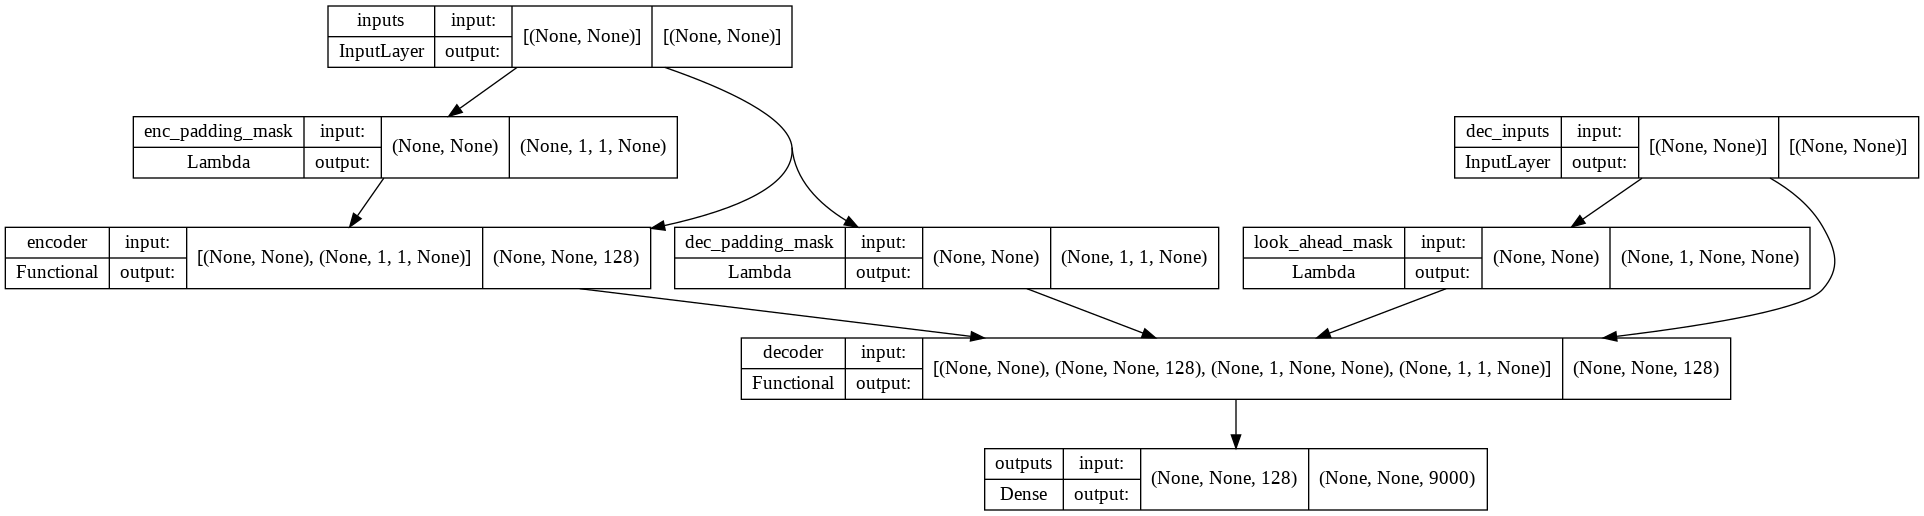

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name = "small_transformer"
)

tf.keras.utils.plot_model(
    small_transformer, to_file="small_transformer.png", show_shapes=True
)

# 손실 함수 정의하기

다중 클래스 분류 문제를 풀기 때문에 크로스 엔트로피 함수를 손실 함수로 정의한다.

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits =True, reduction='none'
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 학습률 (learning rate Scheduler)

학습률 스케쥴러 : 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법

$$ lrate = d^{-0.5}_{model} × min (step\_num^{-0.5}, step\_num × warmup\_steps^{-1.5}) $$

- step_num(단계)란 옵티마이저가 매개변수를 업데이터 하는 한 번의 진행 횟수를 의미
- warmup_steps : step_num이 warmup_steps보다 작을 경우 학습률을 선형적으로 증가시키고, step_num이 warmup_step에 도달하게 되면 학습률을 step_num의 역제곱근에 따라서 감소

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

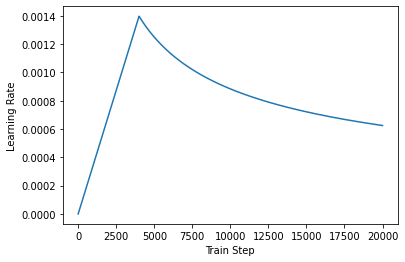

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(20000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')